In [135]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import seaborn as sns
import shap
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import IsolationForest
import joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from functools import partial
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

pd.set_option('display.max_columns', 500)

In [161]:
df1 = pd.read_pickle(r"c:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\data\CH EPRU.pkl")
te = pd.read_excel(r"c:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\data\nové_data\t_e.xlsx")
df1 = df1[df1.index >= "2020-04-01 00:00:00"]

te = te.set_index("DATUM")
te = te[te.index >= "2020-04-01 00:00:00"]
df1.head()

t_e = te
df = df1[["HV Chomutov okamžitý tepelný výkon GJ", "HV Klášterec okamžitý tepelný výkon GJ"]]
 
te = te[["Teplota venkovní"]]
#te = te.resample("1h").mean()
te

df = df.resample("1h").mean()
df["dodavka_tepla"] = df["HV Chomutov okamžitý tepelný výkon GJ"] + df["HV Klášterec okamžitý tepelný výkon GJ"]

df_final = pd.DataFrame()
df_final["Teplota venkovní"] = te["Teplota venkovní"]
df_final["dodavka_tepla"] = df["dodavka_tepla"]
print(df_final.info())
print(df_final.describe())
print(df_final.isnull().sum())

# 🕒 Časové atributy
df_final["hodina"] = df_final.index.hour                 # Hodina dne
df_final["den_v_tydnu"] = df_final.index.dayofweek      # Den v týdnu (0 = pondělí, 6 = neděle)
df_final["mesic"] = df_final.index.month                # Měsíc
df_final["je_leto"] = (df_final.index.month.isin([6,7,8])) | (df_final.index.month.isin([5]) & df_final.index.day.isin(range(15,30))) | (df_final.index.month.isin([9]) & df_final.index.day.isin(range(1,15))) # Letní období
#df_final["den_v_mesici"] = df_final.index.day           # Den v měsíci
#df_final["den_v_roce"] = df_final.index.dayofyear       # Den v roce

print(len(df_final))



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43080 entries, 2020-04-01 00:00:00 to 2025-02-28 23:00:00
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Teplota venkovní  43070 non-null  float64
 1   dodavka_tepla     43079 non-null  float64
dtypes: float64(2)
memory usage: 1009.7 KB
None
       Teplota venkovní  dodavka_tepla
count      43070.000000   43079.000000
mean          11.991342     136.435544
std            8.331205     104.582250
min          -10.988250       0.000000
25%            4.949417      51.958333
50%           11.351264     129.661111
75%           18.424456     209.939583
max           37.236364    9664.579722
Teplota venkovní    10
dodavka_tepla        1
dtype: int64
43080


In [162]:
def hyperparameters(df_final):
    try:
        df_final["hodina"] = df_final.index.hour                 # Hodina dne
        df_final["den_v_tydnu"] = df_final.index.dayofweek      # Den v týdnu (0 = pondělí, 6 = neděle)
        df_final["mesic"] = df_final.index.month                # Měsíc
        df_final["je_leto"] = (df_final.index.month.isin([6,7,8])) | (df_final.index.month.isin([5]) & df_final.index.day.isin(range(15,30))) | (df_final.index.month.isin([9]) & df_final.index.day.isin(range(1,15))) # Letní období
        #df_final["den_v_mesici"] = df_final.index.day           # Den v měsíci
        #df_final["den_v_roce"] = df_final.index.dayofyear       # Den v roce
        
        df_final["month_sin"] = np.sin(2 * np.pi * df_final["mesic"] / 12)
        df_final["month_cos"] = np.cos(2 * np.pi * df_final["mesic"] / 12)

        df_final["hour_sin"] = np.sin(2 * np.pi * df_final["hodina"] / 24)
        df_final["hour_cos"] = np.cos(2 * np.pi * df_final["hodina"] / 24)

        df_final["day_of_week_sin"] = np.sin(2 * np.pi * df_final.index.dayofweek  / 7)
        df_final["day_of_week_cos"] = np.cos(2 * np.pi * df_final.index.dayofweek  / 7)
    
    except:
        return "chyba"
    
    return df_final    

hyperparameters(df_final)

df_final

,Teplota venkovní,dodavka_tepla,hodina,den_v_tydnu,mesic,je_leto,month_sin,month_cos,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos
DATUM,,,,,,,,,,,,
2020-04-01 00:00:00,-1.473025,223.089444,0,2,4,False,0.866025,-0.5,0.000000,1.000000,0.974928,-0.222521
2020-04-01 01:00:00,-1.883056,224.059444,1,2,4,False,0.866025,-0.5,0.258819,0.965926,0.974928,-0.222521
2020-04-01 02:00:00,-2.065617,236.905556,2,2,4,False,0.866025,-0.5,0.500000,0.866025,0.974928,-0.222521
2020-04-01 03:00:00,-2.537593,260.658056,3,2,4,False,0.866025,-0.5,0.707107,0.707107,0.974928,-0.222521
2020-04-01 04:00:00,-2.725833,278.145278,4,2,4,False,0.866025,-0.5,0.866025,0.500000,0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28 19:00:00,2.962500,250.250000,19,4,2,False,0.866025,0.5,-0.965926,0.258819,-0.433884,-0.900969
2025-02-28 20:00:00,2.562500,229.450000,20,4,2,False,0.866025,0.5,-0.866025,0.500000,-0.433884,-0.900969
2025-02-28 21:00:00,2.587500,209.675000,21,4,2,False,0.866025,0.5,-0.707107,0.707107,-0.433884,-0.900969


In [163]:
def outliers_out(df_final, months, a, b):
    monthly_hourly_mean = df_final[df_final["dodavka_tepla"] >= 5].groupby(["mesic", "hodina"])["dodavka_tepla"].mean()

    df_final["dodavka_tepla"] = df_final.apply(
        lambda row: monthly_hourly_mean.loc[row["mesic"], row["hodina"]] 
        if row["dodavka_tepla"] < 5 else row["dodavka_tepla"], 
        axis=1
    )


    month = months

    # Spočítat std a průměr pro jednotlivé hodiny v jednotlivých měsících
    group_stats = df_final[df_final["mesic"].isin(months)].groupby(["mesic", "hodina"])["dodavka_tepla"].agg(["mean", "std"])

    # Funkce pro odtsranění extrémních hodnot
    def replace_extremes(row):
        if row["mesic"] in months:
            mean_val = group_stats.loc[(row["mesic"], row["hodina"]), "mean"]
            std_val = group_stats.loc[(row["mesic"], row["hodina"]), "std"]
            
            lower_bound = a
            upper_bound = b
            #lower_bound = mean_val - 2 * std_val
            #upper_bound = mean_val + 2 * std_val

            if row["dodavka_tepla"] < lower_bound or row["dodavka_tepla"] > upper_bound:
                return mean_val  # Nahradit průměrem
        return row["dodavka_tepla"]  # Necht původní hodnotu

    df_final["dodavka_tepla"] = df_final.apply(replace_extremes, axis=1)

    return df_final

outliers_out(df_final, [6, 7, 8], 20, 100) # leto
outliers_out(df_final, [1,2,3,4,5,9,10,11,12], 0, 1000) # zima

,Teplota venkovní,dodavka_tepla,hodina,den_v_tydnu,mesic,je_leto,month_sin,month_cos,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos
DATUM,,,,,,,,,,,,
2020-04-01 00:00:00,-1.473025,223.089444,0,2,4,False,0.866025,-0.5,0.000000,1.000000,0.974928,-0.222521
2020-04-01 01:00:00,-1.883056,224.059444,1,2,4,False,0.866025,-0.5,0.258819,0.965926,0.974928,-0.222521
2020-04-01 02:00:00,-2.065617,236.905556,2,2,4,False,0.866025,-0.5,0.500000,0.866025,0.974928,-0.222521
2020-04-01 03:00:00,-2.537593,260.658056,3,2,4,False,0.866025,-0.5,0.707107,0.707107,0.974928,-0.222521
2020-04-01 04:00:00,-2.725833,278.145278,4,2,4,False,0.866025,-0.5,0.866025,0.500000,0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28 19:00:00,2.962500,250.250000,19,4,2,False,0.866025,0.5,-0.965926,0.258819,-0.433884,-0.900969
2025-02-28 20:00:00,2.562500,229.450000,20,4,2,False,0.866025,0.5,-0.866025,0.500000,-0.433884,-0.900969
2025-02-28 21:00:00,2.587500,209.675000,21,4,2,False,0.866025,0.5,-0.707107,0.707107,-0.433884,-0.900969


<Axes: xlabel='DATUM'>

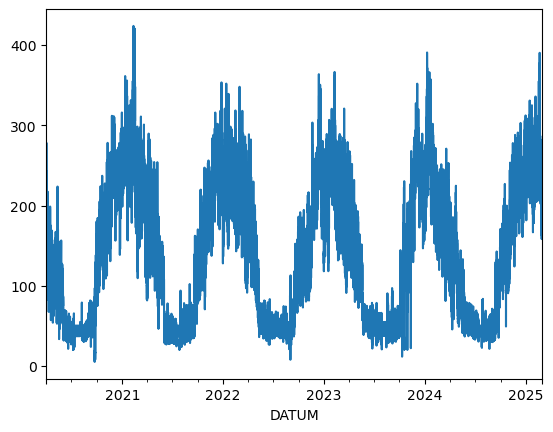

In [164]:
df_final["dodavka_tepla"].plot()

<Axes: xlabel='DATUM'>

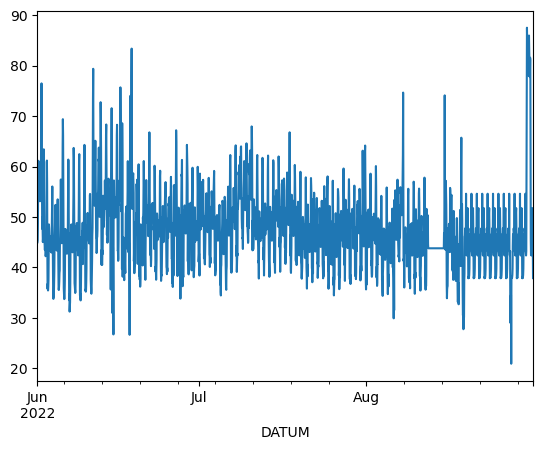

In [165]:
df_final["dodavka_tepla"][(df_final.index >= "2022-06-01 00:00:00") & (df_final.index < "2022-09-01 00:00:00")].plot()

In [166]:
df_final = df_final.dropna()
print(df_final.isnull().sum())

Teplota venkovní    0
dodavka_tepla       0
hodina              0
den_v_tydnu         0
mesic               0
je_leto             0
month_sin           0
month_cos           0
hour_sin            0
hour_cos            0
day_of_week_sin     0
day_of_week_cos     0
dtype: int64


In [167]:
df_final[df_final["dodavka_tepla"] < 10].value_counts().sum()

8

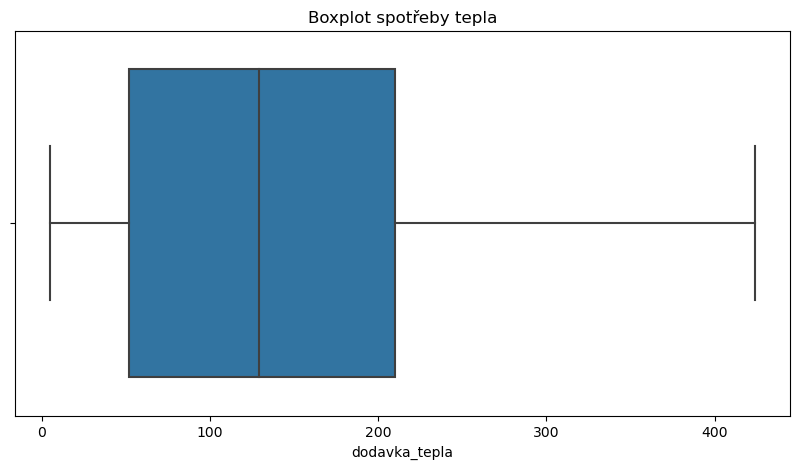

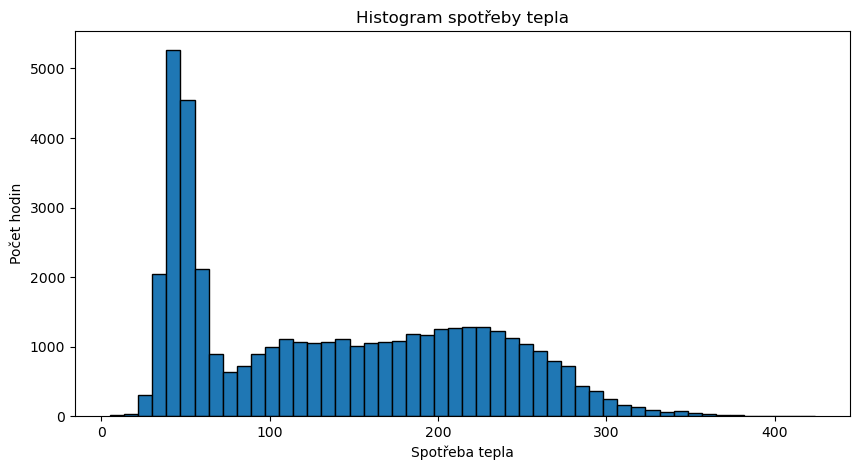

In [168]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_final["dodavka_tepla"])
plt.title("Boxplot spotřeby tepla")
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(df_final["dodavka_tepla"], bins=50, edgecolor="black")
plt.title("Histogram spotřeby tepla")
plt.xlabel("Spotřeba tepla")
plt.ylabel("Počet hodin")
plt.show()

In [169]:
df_final.mean()

Teplota venkovní     11.991342
dodavka_tepla       137.811104
hodina               11.501625
den_v_tydnu           2.999536
mesic                 6.585698
je_leto               0.337126
month_sin            -0.022380
month_cos            -0.002335
hour_sin             -0.000159
hour_cos             -0.000066
day_of_week_sin       0.000770
day_of_week_cos      -0.001076
dtype: float64

In [170]:
print(len(df_final))

43070


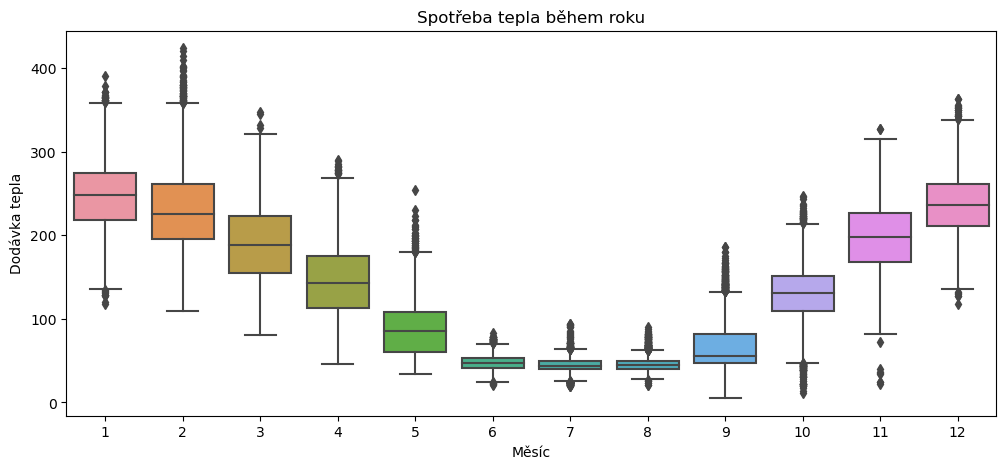

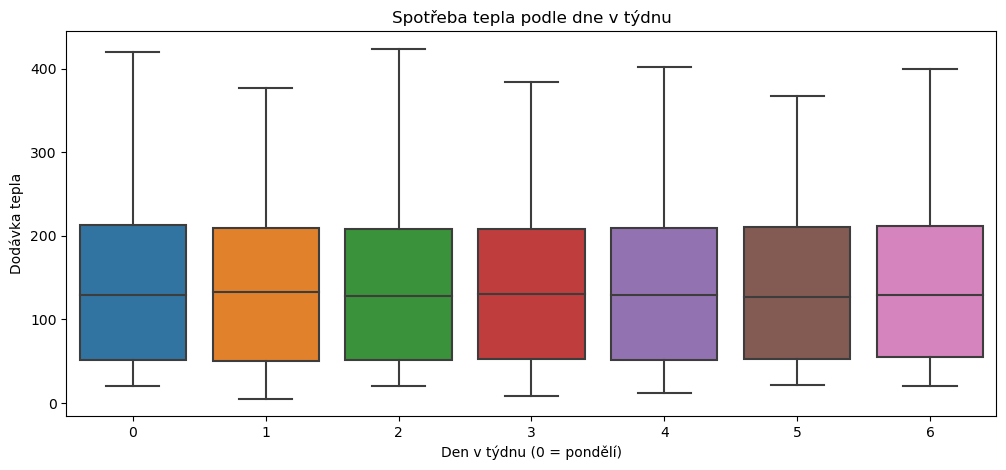

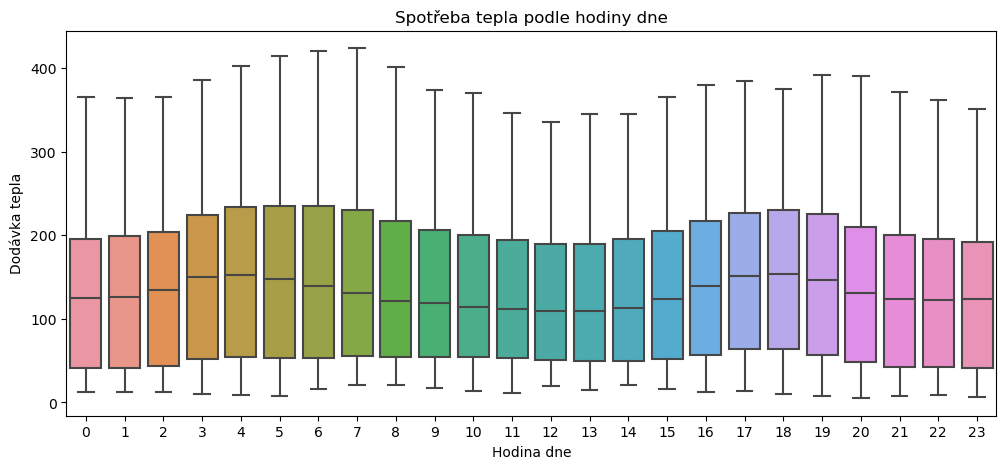

In [171]:
plt.figure(figsize=(12, 5))
sns.boxplot(x="mesic", y="dodavka_tepla", data=df_final)
plt.title("Spotřeba tepla během roku")
plt.xlabel("Měsíc")
plt.ylabel("Dodávka tepla")
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x="den_v_tydnu", y="dodavka_tepla", data=df_final)
plt.title("Spotřeba tepla podle dne v týdnu")
plt.xlabel("Den v týdnu (0 = pondělí)")
plt.ylabel("Dodávka tepla")
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x="hodina", y="dodavka_tepla", data=df_final)
plt.title("Spotřeba tepla podle hodiny dne")
plt.xlabel("Hodina dne")
plt.ylabel("Dodávka tepla")
plt.show()

<Axes: >

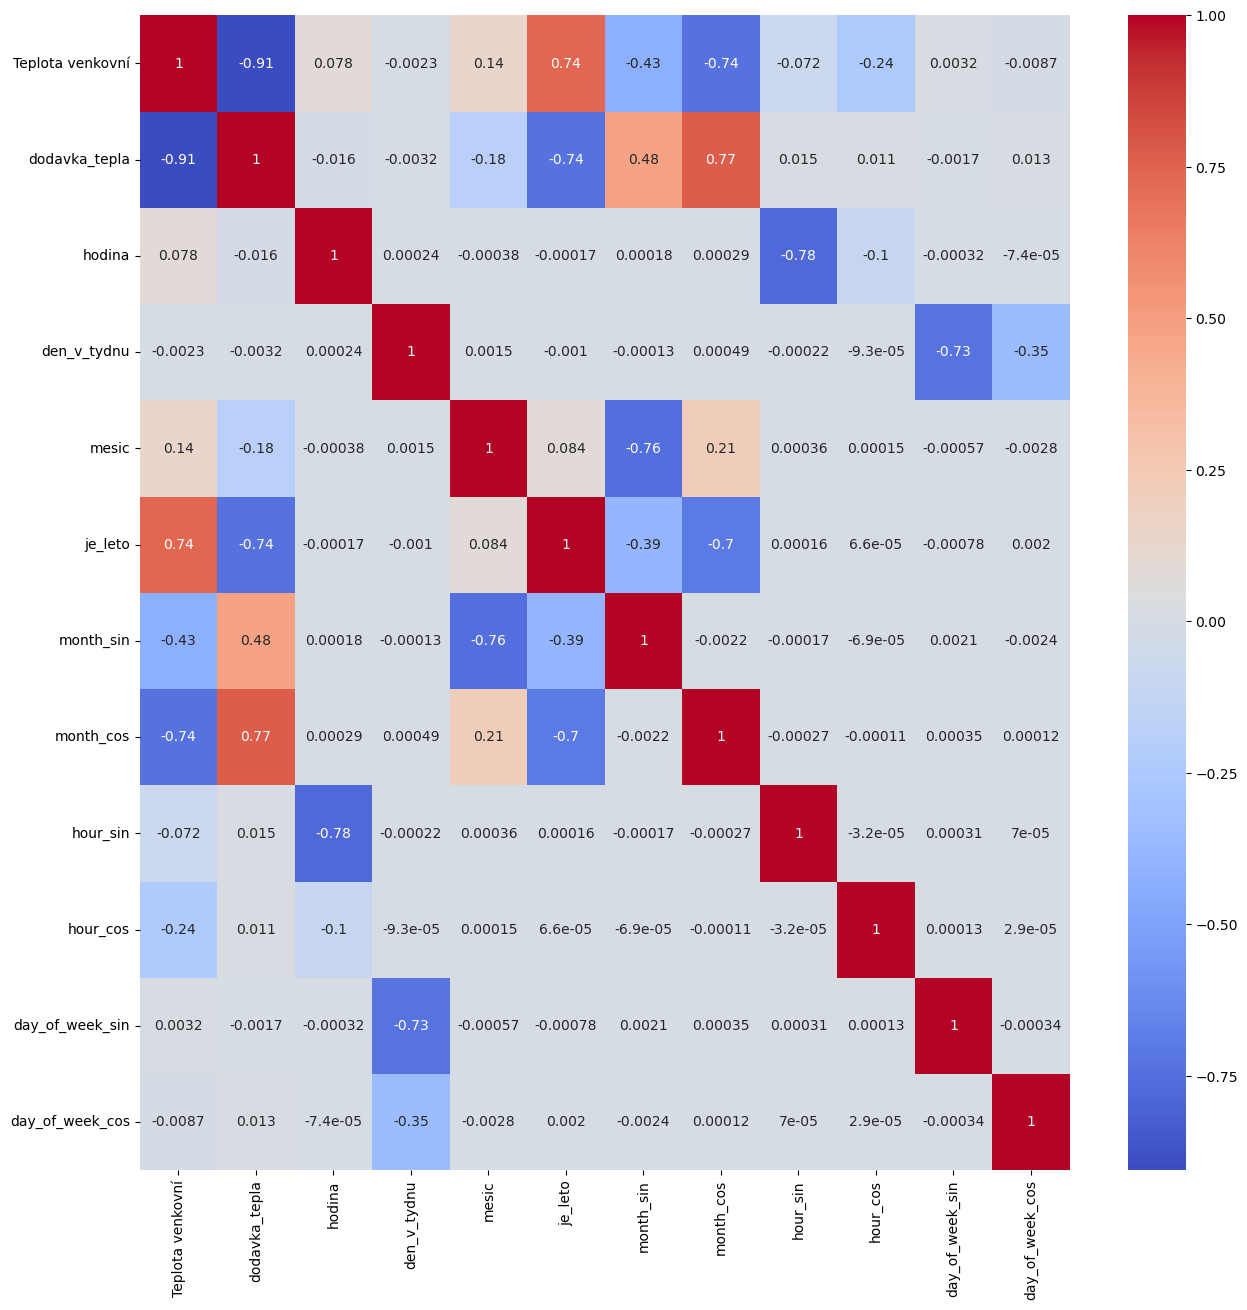

In [172]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_final.corr(), annot=True, cmap="coolwarm")

Vybrané feature: ('Teplota venkovní', 'hodina', 'den_v_tydnu', 'mesic', 'je_leto', 'month_sin', 'month_cos', 'hour_sin', 'day_of_week_sin', 'day_of_week_cos')
Průměrné RMSE skóre: -20.034246831340546


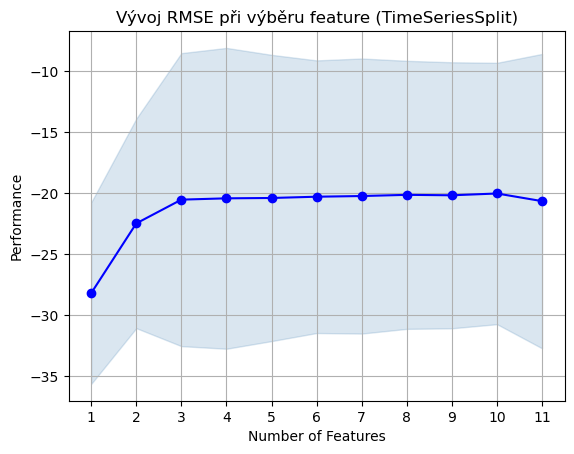

In [173]:
tscv = TimeSeriesSplit(n_splits=25)

y = df_final["dodavka_tepla"]
X = df_final.drop(columns=["dodavka_tepla"])

model = xgb.XGBRegressor(random_state=42)

sfs = SFS(model,
          k_features=(1, 11),                         # nebo (5, 20) pro rozsah
          forward=True,
          floating=False,
          scoring='neg_root_mean_squared_error',
          cv=tscv,                               # použije časové dělení
          n_jobs=-1)                             # paralelizace pro rychlost

sfs = sfs.fit(X, y)

print("Vybrané feature:", sfs.k_feature_names_)
print("Průměrné RMSE skóre:", sfs.k_score_)

# Grafický výstup
plot_sfs(sfs.get_metric_dict())
plt.title("Vývoj RMSE při výběru feature (TimeSeriesSplit)")
plt.grid(True)
plt.show()

In [138]:
df_final = df_final[['Teplota venkovní', 'dodavka_tepla', 'hodina', 'je_leto']]

In [139]:
df_final

,Teplota venkovní,dodavka_tepla,hodina,je_leto
DATUM,,,,
2020-04-01 00:00:00,-1.473025,223.089444,0,False
2020-04-01 01:00:00,-1.883056,224.059444,1,False
2020-04-01 02:00:00,-2.065617,236.905556,2,False
2020-04-01 03:00:00,-2.537593,260.658056,3,False
2020-04-01 04:00:00,-2.725833,278.145278,4,False
...,...,...,...,...
2025-02-28 19:00:00,2.962500,250.250000,19,False
2025-02-28 20:00:00,2.562500,229.450000,20,False
2025-02-28 21:00:00,2.587500,209.675000,21,False


In [156]:
X = df_final.drop(columns=["dodavka_tepla"])  # Vše kromě množství tepla
y = df_final["dodavka_tepla"]                 # Požadované množství tepla
#y = np.log1p(df_final["dodavka_tepla"])

def custom_time_series_split(X, y, n_splits=10, first_train_size=0.5, test_size=24*6*30):
    #Vytvoří vlastní TimeSeriesSplit s rostoucím trénovacím oknem a fixní testovací velikostí.
    n_samples = len(X)
    first_train_end = int(n_samples * first_train_size)  
    test_start = first_train_end
    splits = []

    for i in range(n_splits):
        if test_start + test_size > n_samples:
            break  

        train_index = list(range(test_start))  # Trénovací sada roste
        test_index = list(range(test_start, test_start + test_size))  

        splits.append((train_index, test_index))
        test_start += test_size  # Posun testovací sady o 6 měsíců

    return splits

#Vygenerujeme foldy
splits = custom_time_series_split(X, y, n_splits=10, first_train_size=0.5, test_size=24*6*30)


def xgb_cv(n_estimators, max_depth, learning_rate, reg_alpha, reg_lambda, early_stopping_rounds, min_child_weight, gamma):
    """Optimalizační funkce pro Bayesian Optimization."""
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    early_stopping_rounds = int(early_stopping_rounds)
    errors = []
    
    for fold, (train_index, test_index) in enumerate(splits):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = xgb.XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            reg_alpha = reg_alpha,
            reg_lambda = reg_lambda,
            eval_metric="rmse",  # Optimalizujeme podle RMSE
            early_stopping_rounds=early_stopping_rounds,
            min_child_weight = min_child_weight,
            gamma = gamma,            
            random_state=42
        )
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=False
        )

        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        errors.append(rmse)

    return -np.mean(errors)  # Záporné, protože BO maximalizuje

# Nastavení rozsahu hyperparametrů pro optimalizaci
param_bounds = {
    "n_estimators": (10, 1000),
    "max_depth": (1, 20),
    "learning_rate": (0.001, 0.5),
    "reg_alpha": (10, 200),   # Rozsah L1 regularizace
    "reg_lambda": (10,200),    # Rozsah L2 regularizace
    "early_stopping_rounds": (1, 150),
    "min_child_weight": (5, 30),
    "gamma": (0, 10), # snižuje větvení stromů
}

# Spuštění Bayesian Optimization
optimizer = BayesianOptimization(
    f=xgb_cv, 
    pbounds=param_bounds, 
    random_state=42, 
    allow_duplicate_points=True
)


optimizer.set_gp_params(alpha=1e-4)  # Nastavení Gaussian Process parametrů
optimizer.maximize(init_points=15, n_iter=15)

# Nejlepší parametry
print("Nejlepší parametry:", optimizer.max)

|   iter    |  target   | early_... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------
| 1         | -20.36    | 56.81     | 9.507     | 0.3663    | 12.37     | 8.9       | 164.4     | 21.04     | 174.6     |
| 2         | -21.47    | 90.57     | 7.081     | 0.01127   | 19.43     | 25.81     | 220.2     | 44.55     | 44.85     |
| 3         | -20.24    | 46.33     | 5.248     | 0.2165    | 6.533     | 20.3      | 148.1     | 65.51     | 79.61     |
| 4         | -20.21    | 68.95     | 7.852     | 0.1006    | 10.77     | 19.81     | 55.99     | 125.4     | 42.4      |
| 5         | -20.41    | 10.69     | 9.489     | 0.4829    | 16.36     | 12.62     | 106.7     | 140.0     | 93.63     |
| 6         | -20.2     | 19.18     | 4.952     | 0.01816   | 18.28     | 11.47     | 665.9     | 69.23     | 108.8     |
| 7         | -20.4     

📌 Fold 1: MAE=20.17, RMSE=25.17, R2=0.83, MAPE = 0.12, SMAPE = 11.90, Průměr = 188.98, Minimum = 61.51, Testing Error = 0.03, Training Error = 0.04
📌 Fold 2: MAE=9.55, RMSE=13.75, R2=0.93, MAPE = 0.13, SMAPE = 12.36, Průměr = 83.97, Minimum = 20.67, Testing Error = 633.50, Training Error = 317.08
📌 Fold 3: MAE=20.02, RMSE=27.78, R2=0.87, MAPE = 0.22, SMAPE = 15.55, Průměr = 181.10, Minimum = 11.64, Testing Error = 189.01, Training Error = 359.38
📌 Fold 4: MAE=9.39, RMSE=14.01, R2=0.91, MAPE = 0.12, SMAPE = 11.97, Průměr = 78.74, Minimum = 21.30, Testing Error = 771.56, Training Error = 320.88


📌 FINAL MODEL:  MAE=11.27, RMSE=15.99, R2=0.96, MAPE = 0.10, SMAPE = 9.86, Průměr = 137.01, Minimum = 21.30, Testing Error=255.77, Training Error=373.21


Fold 1: Train 2020-04-01 00:00:00 - 2022-09-15 16:00:00
Test 2022-09-15 17:00:00 - 2023-03-14 16:00:00

Fold 2: Train 2020-04-01 00:00:00 - 2023-03-14 16:00:00
Test 2023-03-14 17:00:00 - 2023-09-10 16:00:00

Fold 3: Train 2020-04-01 00:00:00 -

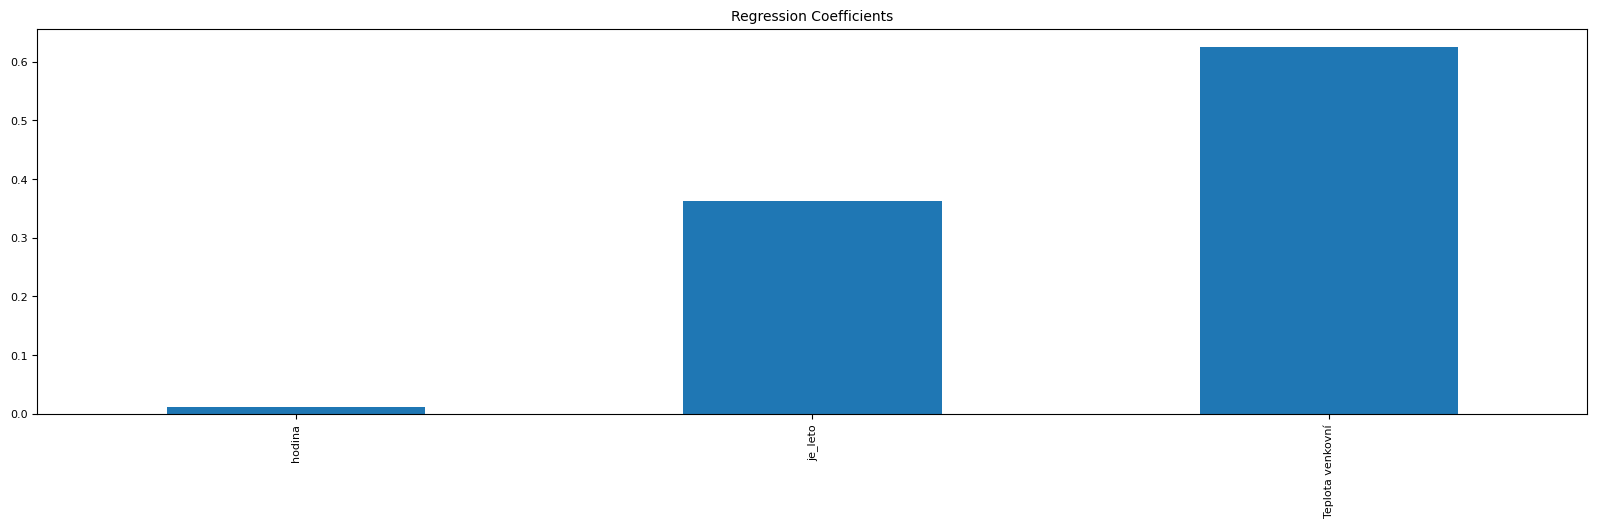

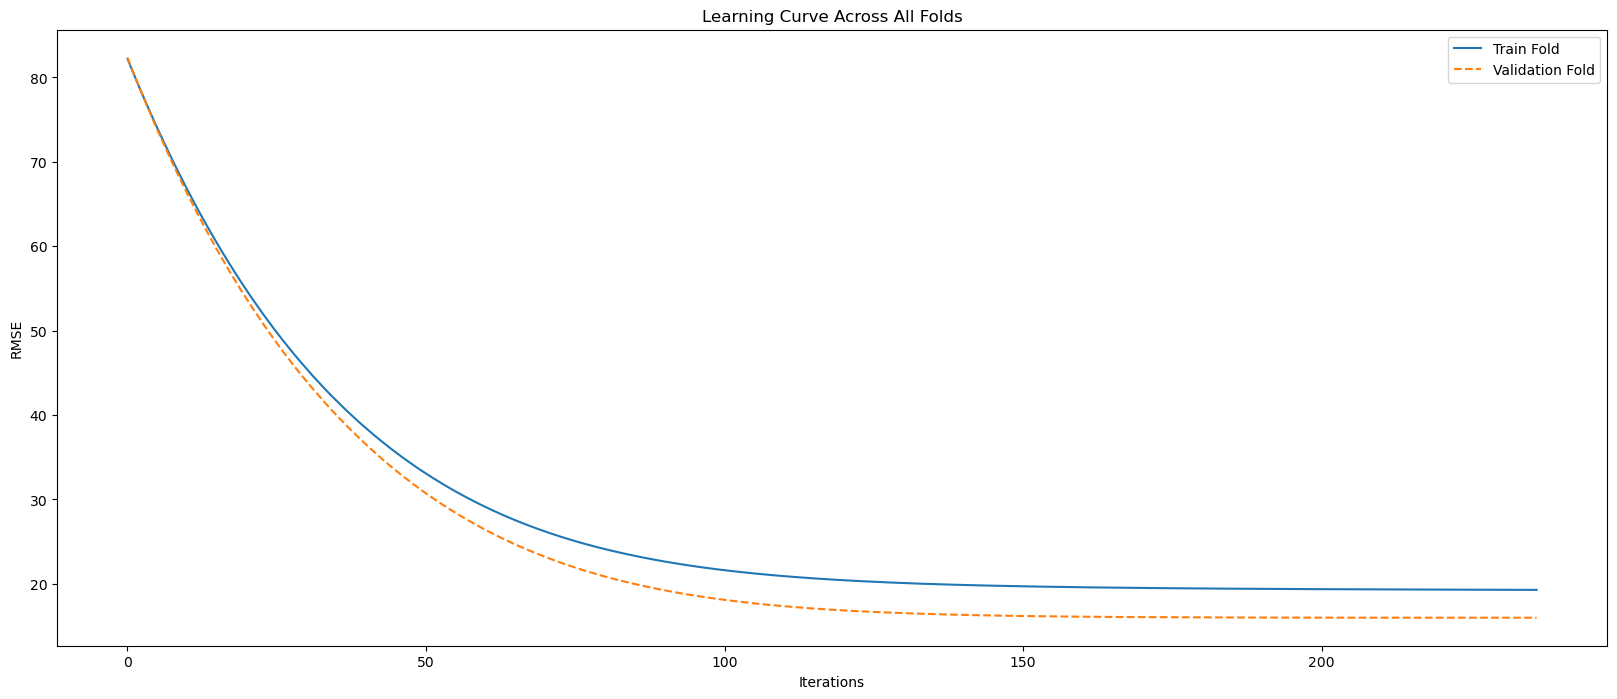

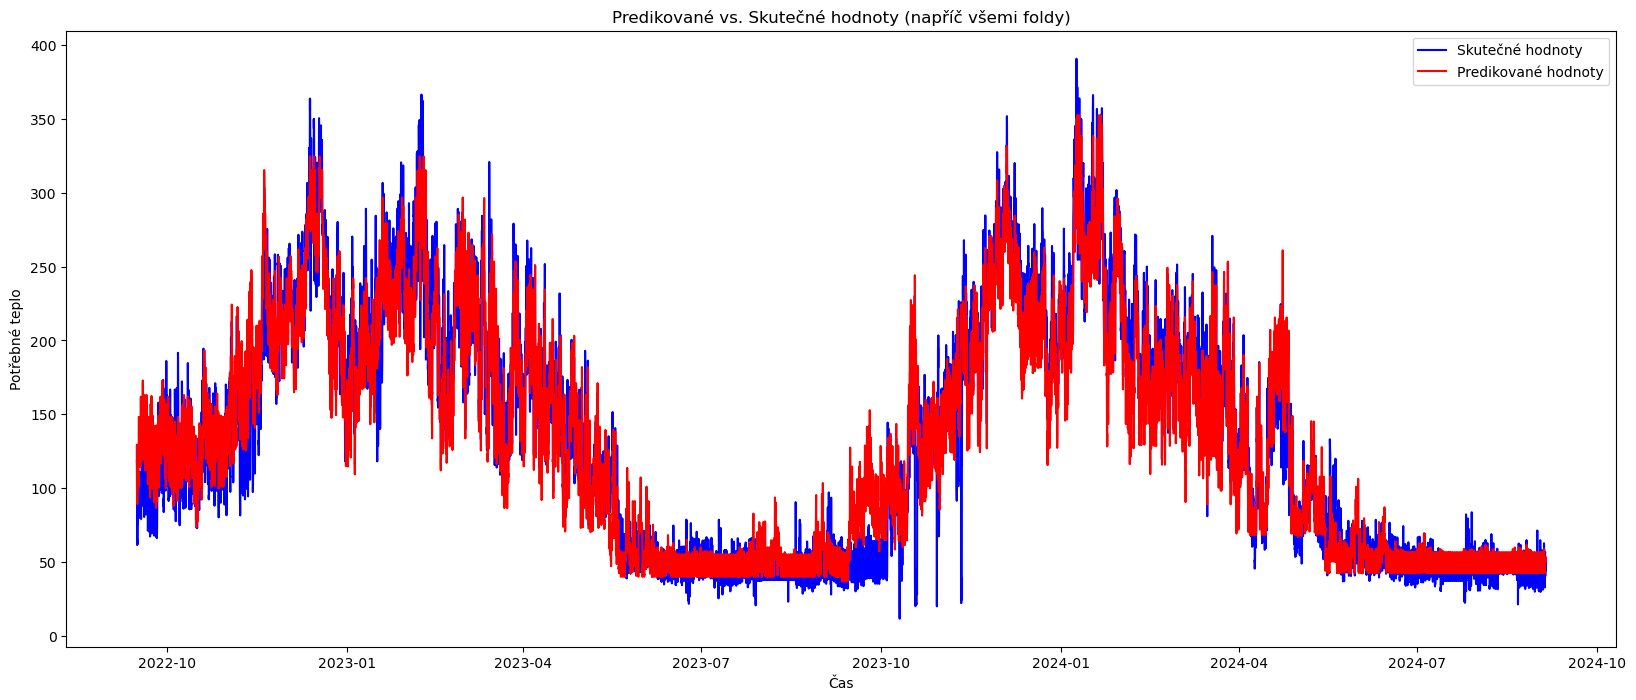

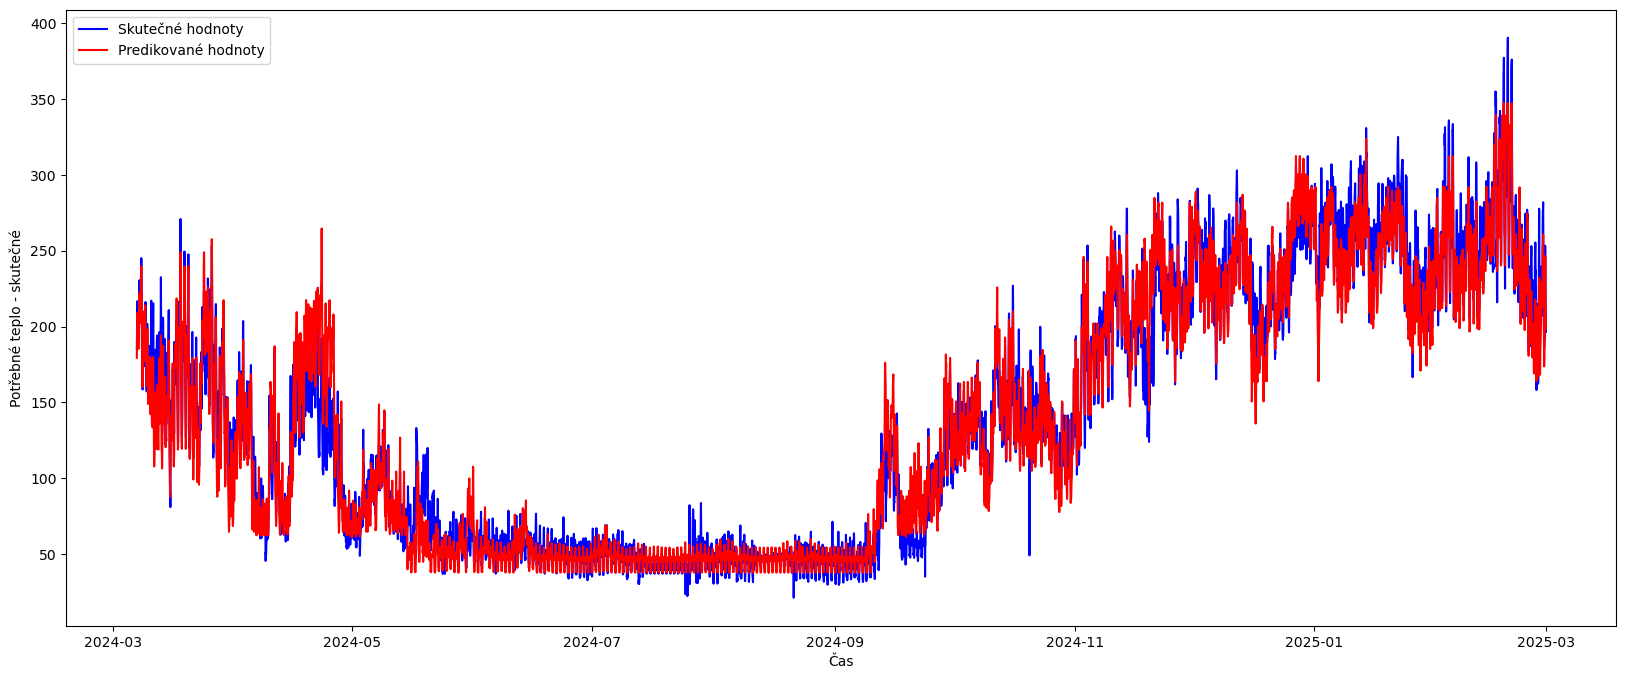

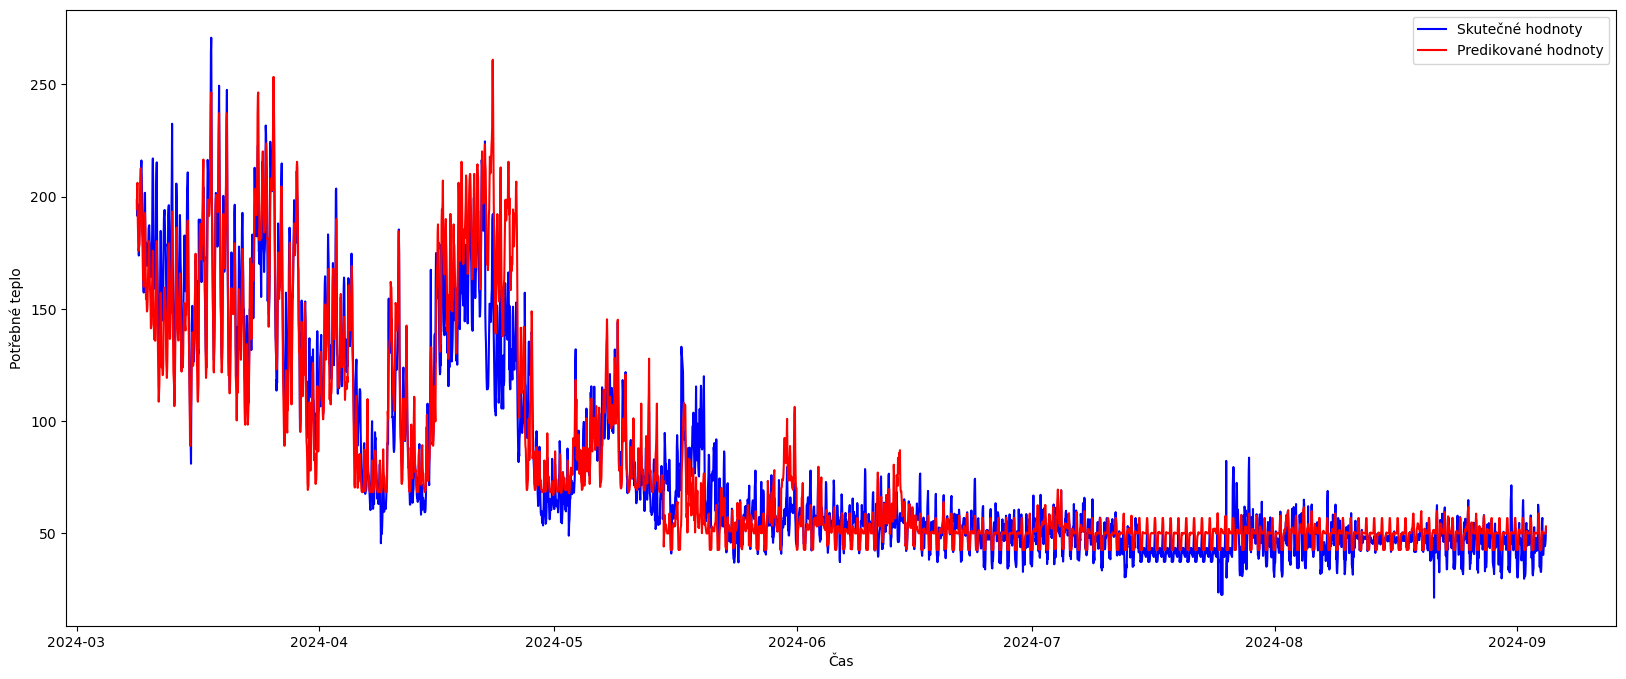

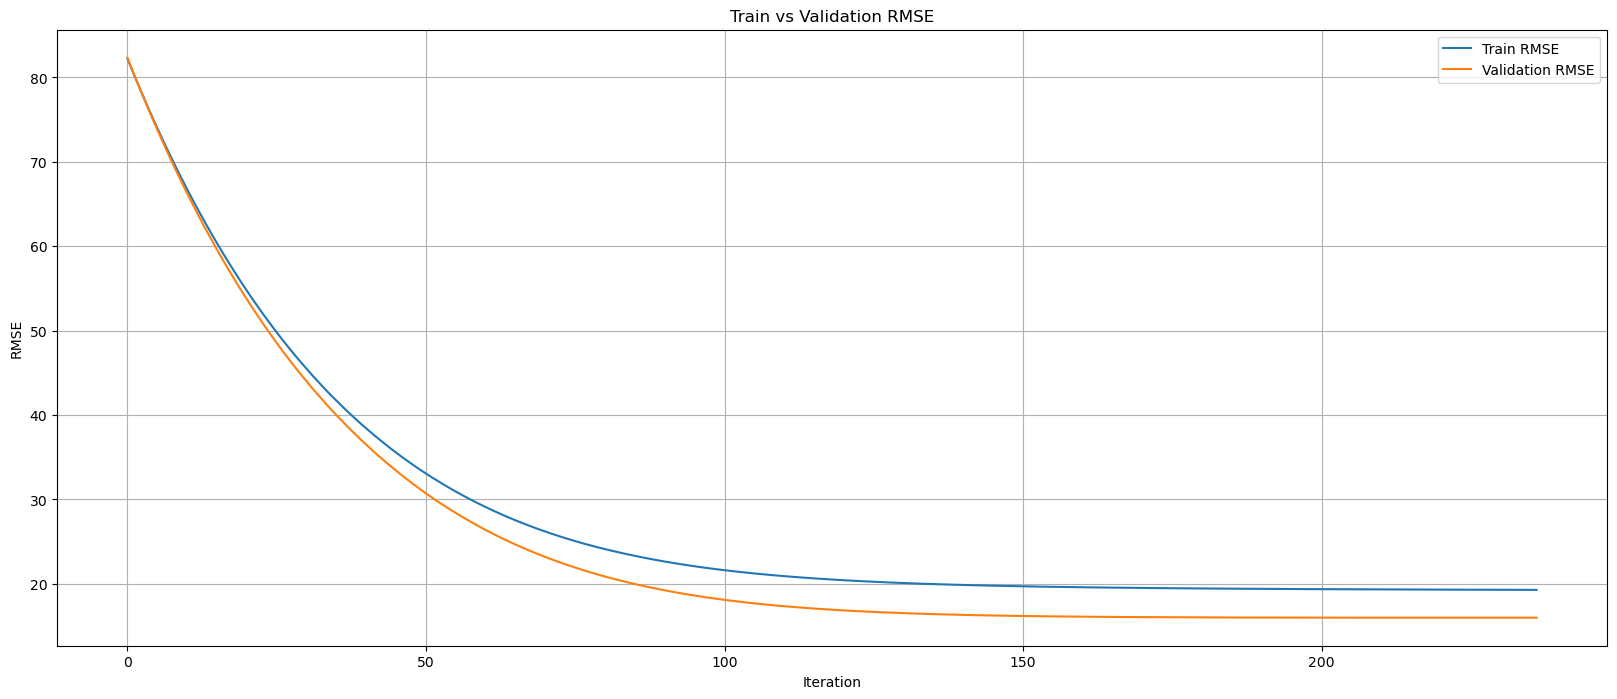

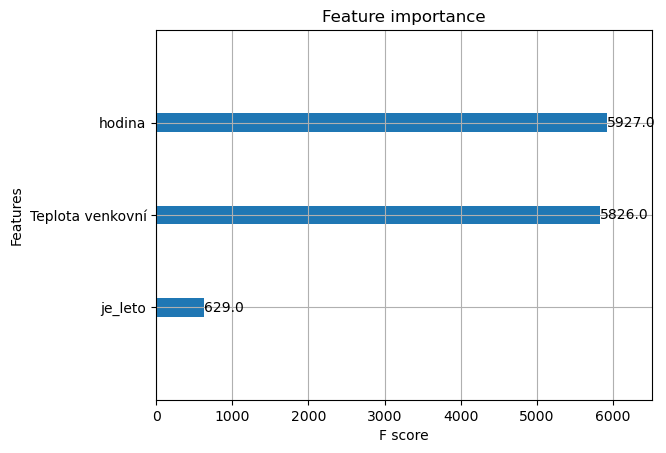

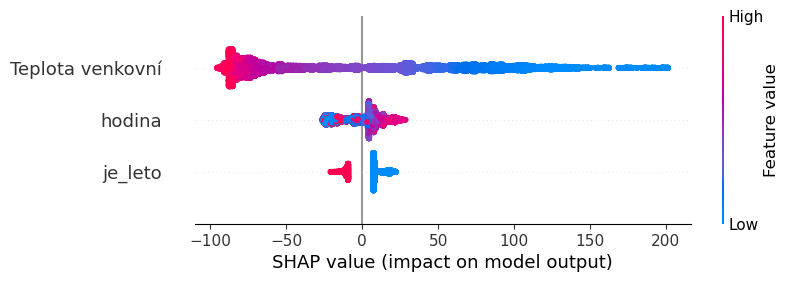

In [ ]:
# Time Series Cross Validation
X = df_final.drop(columns=["dodavka_tepla"]) 
y = df_final["dodavka_tepla"]    
#y = np.log1p(df_final["dodavka_tepla"]) #hodně výkyvů?? lepší pro predikci špiček

def custom_time_series_split_skut(X, y, n_splits=10, first_train_size=0.375, test_size=24*6*30):
    #Vytvoří vlastní TimeSeriesSplit s rostoucím trénovacím oknem a fixní testovací velikostí.
    n_samples = len(X)
    first_train_end = int(first_train_size * n_samples)  
    test_start = first_train_end
    splits = []
    for i in range(n_splits):
        if test_start + test_size > n_samples:
            break  

        train_index = list(range(test_start))
        test_index = list(range(test_start, test_start + test_size))  

        splits.append((train_index, test_index))
        test_start += test_size  # Posun testovací sady o 6 měsíců

    return splits

#Vygenerujeme foldy
splits = custom_time_series_split_skut(X, y, n_splits=10, first_train_size=0.5, test_size=24*6*30)

mae_scores, rmse_scores, r2_scores , mape_scores= [], [], [], []
all_preds, all_test_indices = [], []
train_rmse_all, val_rmse_all = [], []

output_1 = []

# Cross-validation
for fold, (train_index, test_index) in enumerate(splits):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    evals_result = {}  # Store training progress


    final_model = xgb.XGBRegressor(
        #n_estimators = 450,
        n_estimators = int(optimizer.max["params"]["n_estimators"]),
        #max_depth = 7,
        max_depth = int(optimizer.max["params"]["max_depth"]),
        #learning_rate= 0.01,
        learning_rate= float(optimizer.max["params"]["learning_rate"]),
        reg_alpha = float(optimizer.max["params"]["reg_alpha"]),
        #reg_alpha = 15,
        reg_lambda = float(optimizer.max["params"]["reg_lambda"]),
        #reg_lambda = 10,
        gamma = int(optimizer.max["params"]["gamma"]),
        min_child_weight=int(optimizer.max["params"]["min_child_weight"]),
        eval_metric="rmse",
        random_state=42,
        early_stopping_rounds=int(optimizer.max["params"]["early_stopping_rounds"]),
        #early_stopping_rounds=40, 
    )

    final_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False, 
    )

    # Make predictions
    y_pred = final_model.predict(X_test)

    # Store errors
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mean = y_test.mean()
    min = y_test.min()
    reliability_flag = "✅" if mean > 60 and min > 5 else "⚠️"
    def smape(y_true, y_pred):
        return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100
    smape_val = smape(y_test.values, y_pred)
    # Store learning curve data
    #train_rmse_all.append(final_model.evals_result()['validation_0']['rmse'])
    #val_rmse_all.append(final_model.evals_result()['validation_1']['rmse'])
  
    # Store predictions for visualization
    all_preds.extend(y_pred)
    all_test_indices.extend(y_test.index)

    print(f"📌 Fold {fold+1}: MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.2f}, MAPE = {mape:.2f}, SMAPE = {smape_val:.2f}, Průměr = {mean:.2f}, Minimum = {min:.2f}, Testing Error = {MSE_test:.2f}, Training Error = {MSE_train:.2f}")
    
    pred_train = final_model.predict(X_train)
    MSE_train = np.mean((pred_train - y_train)**2)

    pred_test = final_model.predict(X_test)
    MSE_test = mean_squared_error(y_test, pred_test)
    
    output_1.append({
        "Fold": fold + 1,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "R2": round(r2, 2),
        "MAPE": round(mape, 2),
        "SMAPE": round(smape_val, 2),
        "Průměr": round(mean, 2),
        "Minimum": round(min, 2),
        "Testing Error": round(MSE_test, 2),
        "Training Error": round(MSE_train, 2)
    })

    #print(f"   Testing Error={MSE_test:.2f}, Training Error={MSE_train:.2f}")

out_df = pd.DataFrame(output_1)

#out_df = out_df.set_index("Fold")

# 🟢 Train final model on full dataset
evals_result_final = {}  # Reset pro finální trénování

n_train = int(len(X) * 0.8)  # 80 % dat pro trénink
X_train_eval = X.iloc[:n_train]
y_train_eval = y.iloc[:n_train]

X_val = X.iloc[n_train:]
y_val = y.iloc[n_train:]

final_model.fit(
    X_train_eval, y_train_eval,
    eval_set=[(X_train_eval, y_train_eval), (X_val, y_val)],
    verbose=False
)

train_rmse_all.append(final_model.evals_result()['validation_0']['rmse'])
val_rmse_all.append(final_model.evals_result()['validation_1']['rmse'])

print("\n")

y_pred_skut = final_model.predict(X_val)
#########################################

mae = mean_absolute_error(y_val, y_pred_skut)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_skut))
r2 = r2_score(y_val, y_pred_skut)
mape = mean_absolute_percentage_error(y_val, y_pred_skut)
mean = y_val.mean()
min = y_val.min()
def smape(y_true, y_pred_skut):
    return np.mean(2 * np.abs(y_pred_skut - y_true) / (np.abs(y_true) + np.abs(y_pred_skut))) * 100
smape_val = smape(y_val.values, y_pred_skut)

pred_train = final_model.predict(X_train_eval)
MSE_train = np.mean((pred_train - y_train_eval)**2)

pred_test = final_model.predict(X_val)
MSE_test = mean_squared_error(y_val, pred_test)

print(f"📌 FINAL MODEL:  MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.2f}, MAPE = {mape:.2f}, SMAPE = {smape_val:.2f}, Průměr = {mean:.2f}, Minimum = {min:.2f}, Testing Error={MSE_test:.2f}, Training Error={MSE_train:.2f}")
print("\n")

########################################
for fold, (train_index, test_index) in enumerate(splits):
    print(f"Fold {fold+1}: Train {X.iloc[train_index].index.min()} - {X.iloc[train_index].index.max()}")
    print(f"Test {X.iloc[test_index].index.min()} - {X.iloc[test_index].index.max()}\n")

importances = final_model.feature_importances_
coef = pd.Series(importances, index=X.columns).sort_values()
plt.figure(figsize = (20,5))
coef.plot(kind='bar', fontsize = 8)
plt.title ("Regression Coefficients", fontsize = 10)
plt.show()


plt.figure(figsize=(20, 8))
plt.plot(train_rmse_all[0], label="Train Fold")
plt.plot(val_rmse_all[0], label="Validation Fold", linestyle="dashed")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("Learning Curve Across All Folds")
plt.show()

# Visualize predictions vs actual values
plt.figure(figsize=(20, 8))
plt.plot(all_test_indices, y.loc[all_test_indices], label="Skutečné hodnoty", color="blue")
plt.plot(all_test_indices, all_preds, label="Predikované hodnoty", color="red")
plt.xlabel("Čas")
plt.ylabel("Potřebné teplo")
plt.legend()
plt.title("Predikované vs. Skutečné hodnoty (napříč všemi foldy)")
plt.show()


# Vizualizace predikovaných vs. skutečných hodnot
plt.figure(figsize=(20, 8))
plt.plot(X_val.index, y_val, label="Skutečné hodnoty", color="blue")
plt.plot(X_val.index, y_pred_skut, label="Predikované hodnoty", color="red")
plt.xlabel("Čas")
plt.ylabel("Potřebné teplo - skutečné")
plt.legend()
plt.show()

# Vizualizace predikovaných vs. skutečných hodnot
plt.figure(figsize=(20, 8))
plt.plot(y_test.index, y_test, label="Skutečné hodnoty", color="blue")
plt.plot(y_test.index, y_pred, label="Predikované hodnoty", color="red")
plt.xlabel("Čas")
plt.ylabel("Potřebné teplo")
plt.legend()
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(train_rmse_all[0], label="Train RMSE", linestyle="-")
plt.plot(val_rmse_all[0], label="Validation RMSE", linestyle="-")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Train vs Validation RMSE")
plt.legend()
plt.grid()
plt.show()


xgb.plot_importance(final_model)
plt.show()

explainer = shap.Explainer(final_model)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values)


Fold=0,Testing Error=633.50, Training Error=317.08


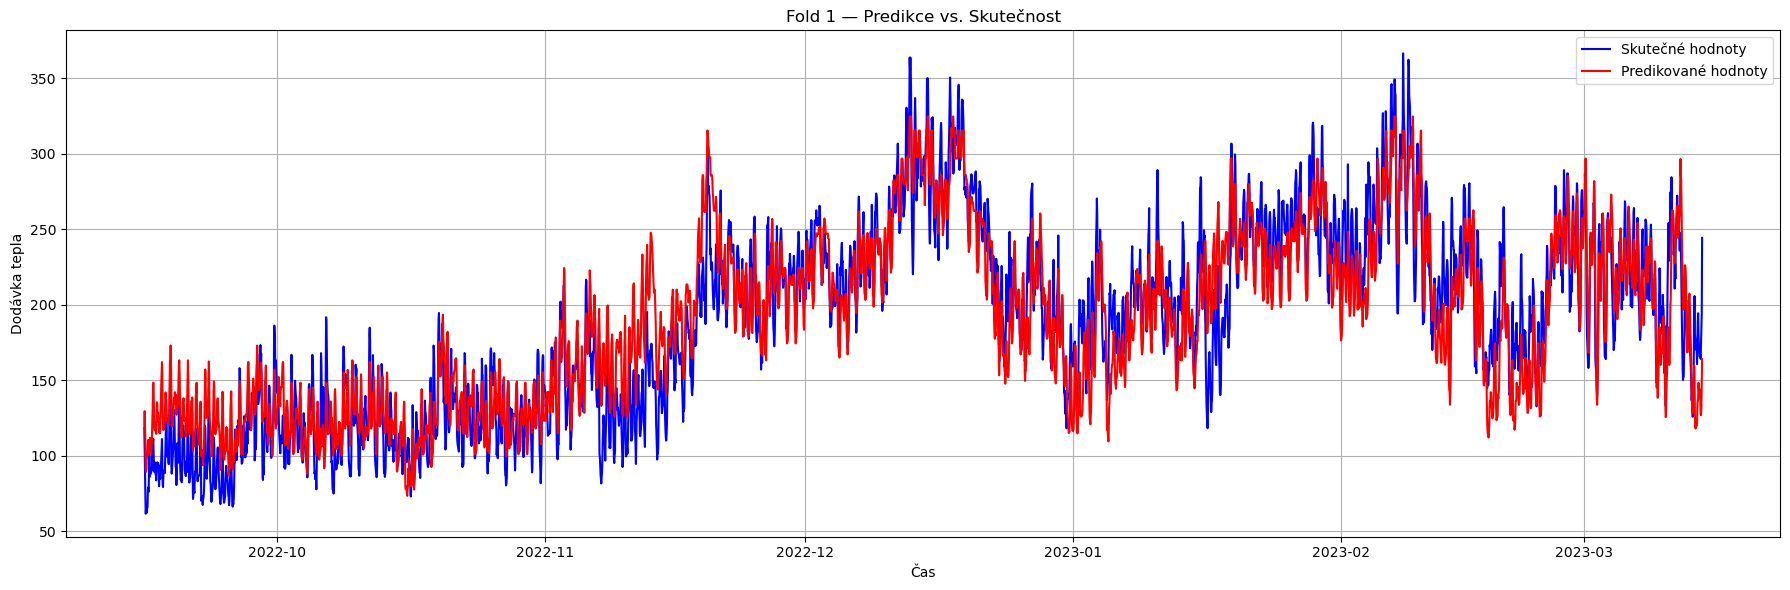

Fold=1,Testing Error=189.01, Training Error=359.38


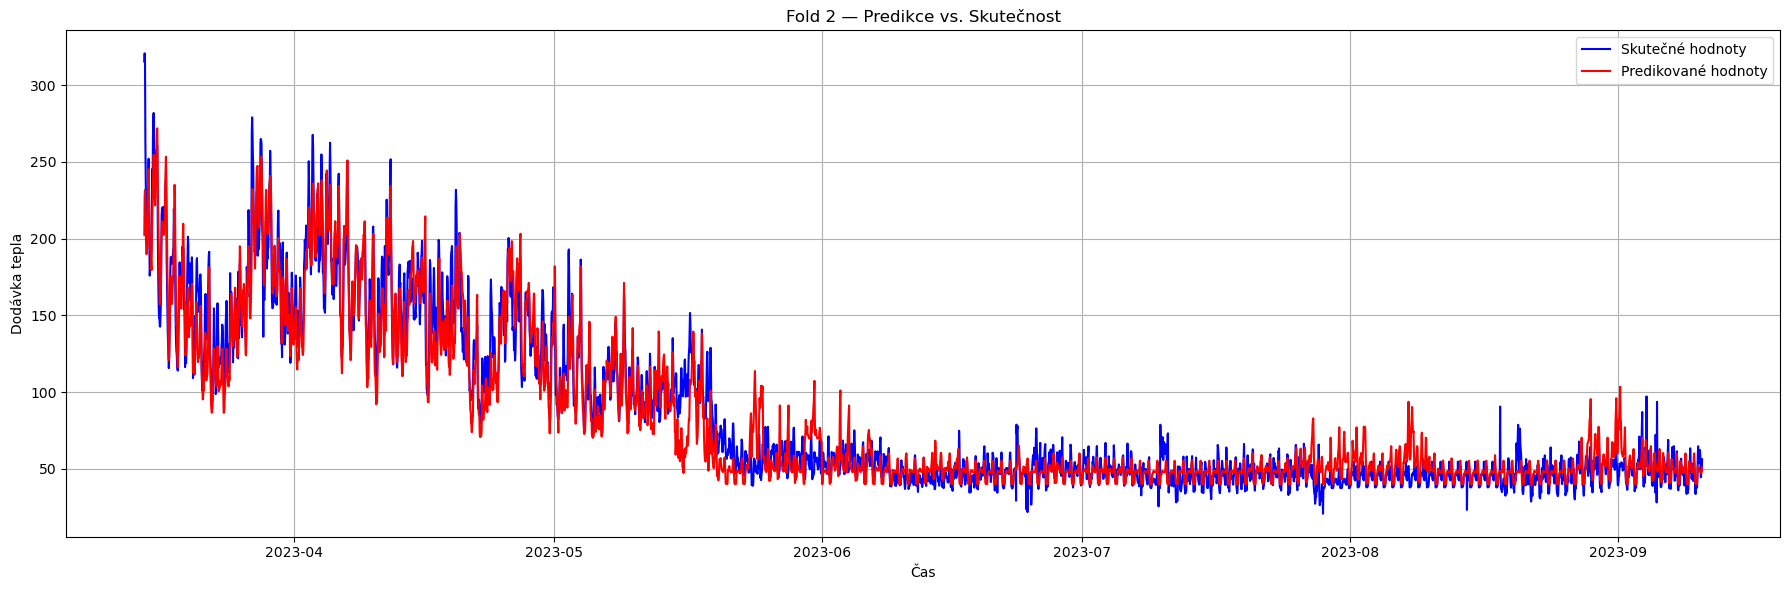

Fold=2,Testing Error=771.56, Training Error=320.88


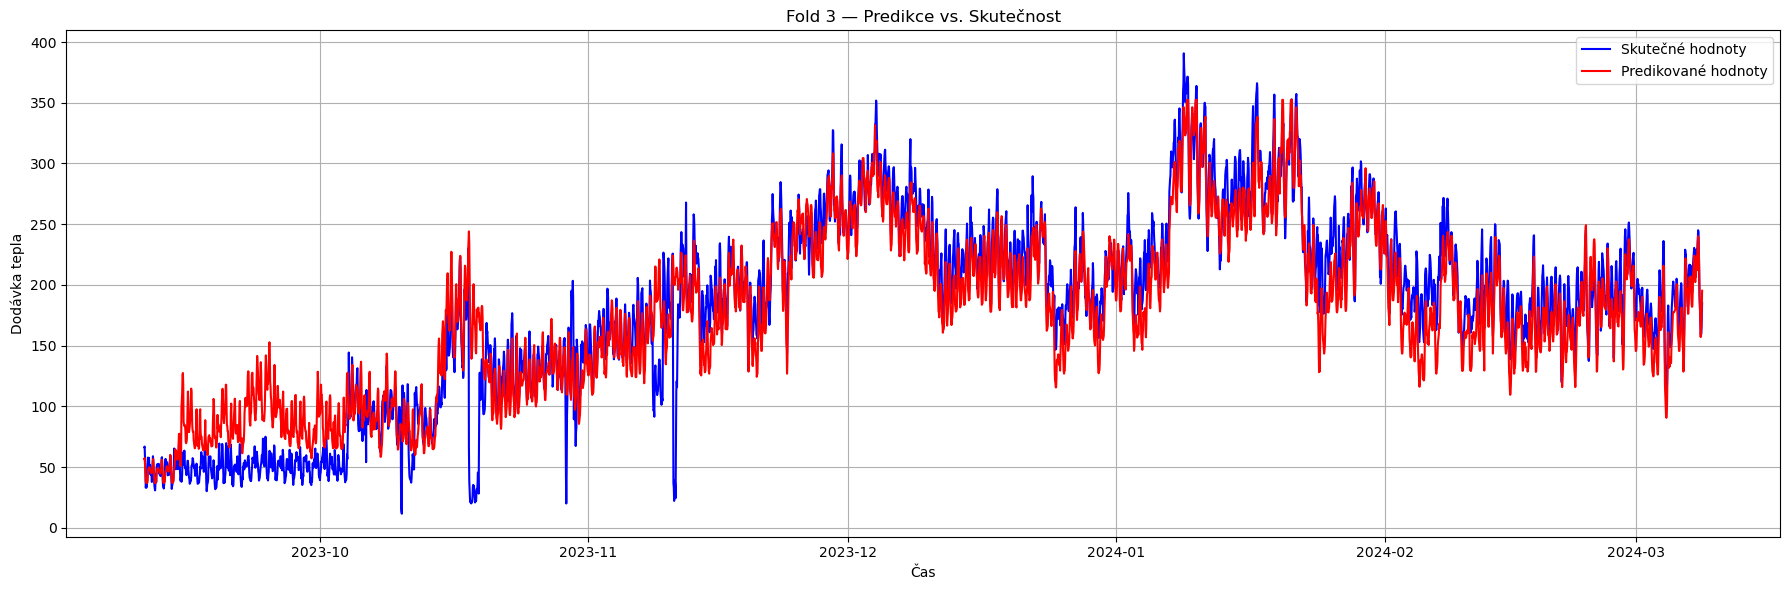

Fold=3,Testing Error=196.41, Training Error=394.79


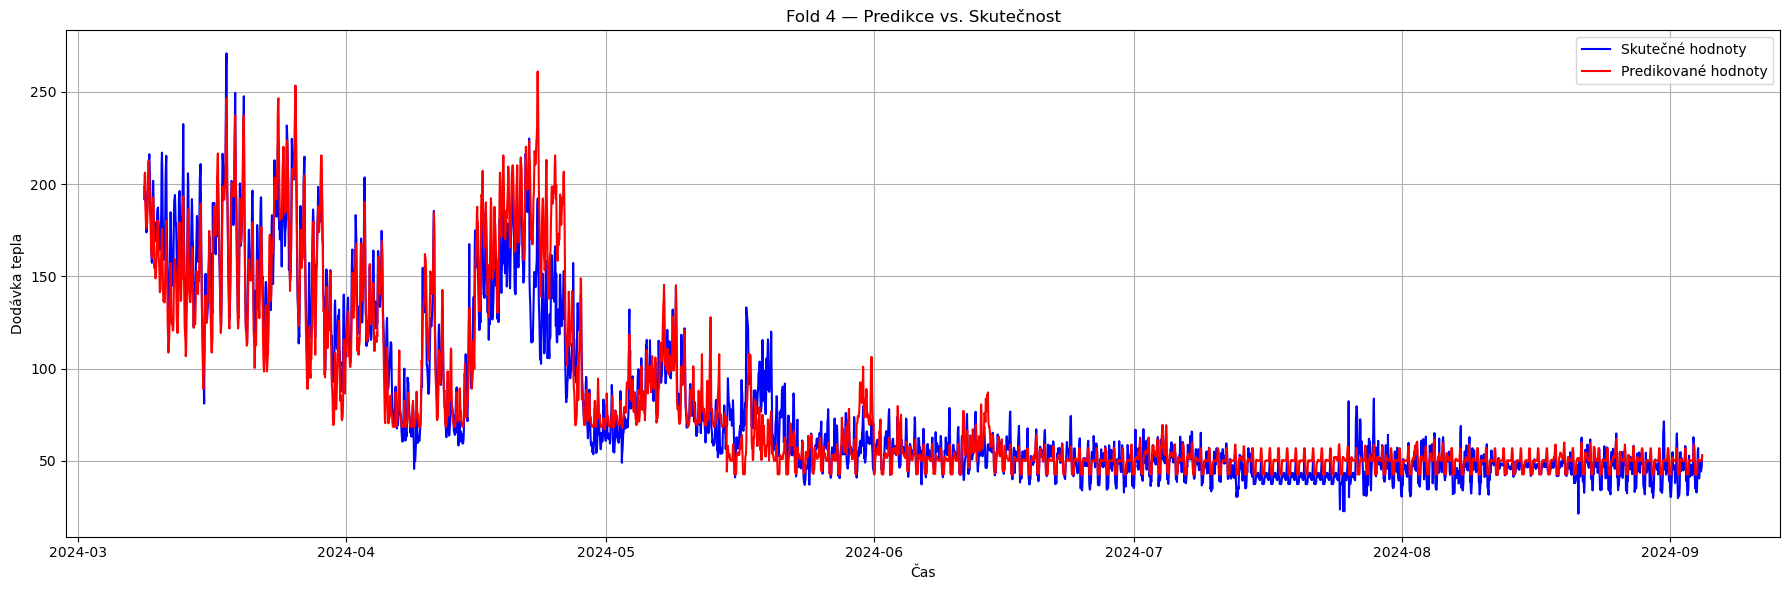

In [158]:
for fold, (train_index, test_index) in enumerate(splits):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    final_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False
    )

    pred_train = final_model.predict(X_train)
    MSE_train = np.mean((pred_train - y_train)**2)

    pred_test = final_model.predict(X_test)
    MSE_test = np.mean((pred_test - y_test)**2)

    print(f"Fold={fold},Testing Error={MSE_test:.2f}, Training Error={MSE_train:.2f}")


    y_pred = final_model.predict(X_test)

    plt.figure(figsize=(18, 6))
    plt.plot(y_test.index, y_test, label="Skutečné hodnoty", color="blue")
    plt.plot(y_test.index, y_pred, label="Predikované hodnoty", color="red")
    plt.xlabel("Čas")
    plt.ylabel("Dodávka tepla")
    plt.title(f"Fold {fold+1} — Predikce vs. Skutečnost")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

MAE=11.27, RMSE=15.99, R2=0.96, MAPE = 0.10, SMAPE = 11.51, Průměr = 137.81, Minimum = 5.09


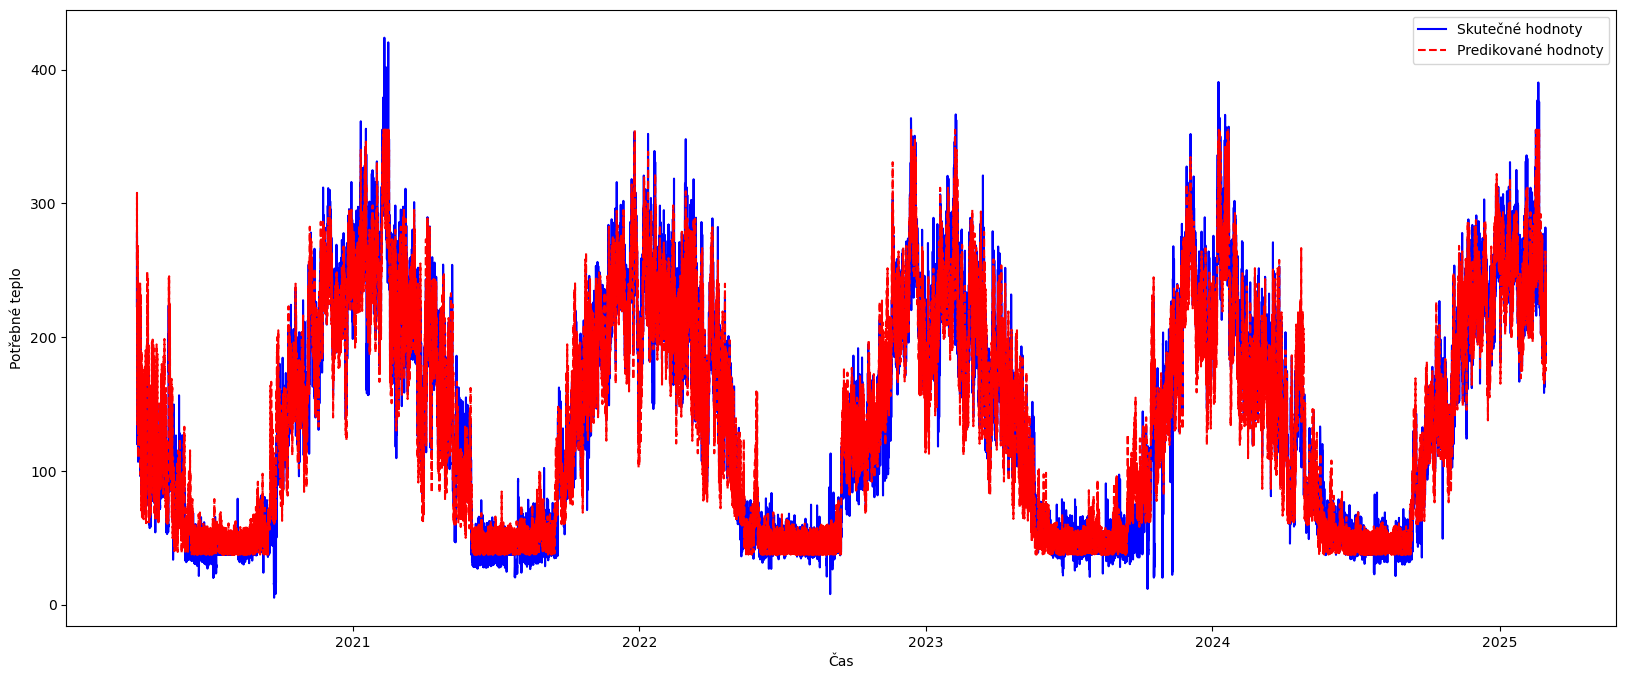

✅ Model byl úspěšně natrénován a uložen!


In [159]:
final_model.set_params(early_stopping_rounds=None)
final_model.fit(X, y, verbose=False)

y_pred_skut = final_model.predict(X)

mae_s = mean_absolute_error(y, y_pred_skut)
rmse_s = np.sqrt(mean_squared_error(y, y_pred_skut))
r2_s = r2_score(y, y_pred_skut)
mape_s = mean_absolute_percentage_error(y, y_pred_skut)

mae_scores.append(mae_s)
rmse_scores.append(rmse_s)
r2_scores.append(r2_s)
mape_scores.append(mape_s)
mean = y.mean()
min = y.min()
def smape(y, y_pred_skut):
    return np.mean(2 * np.abs(y_pred_skut - y) / (np.abs(y) + np.abs(y_pred_skut))) * 100
smape_val = smape(y.values, y_pred_skut)

print(f"MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.2f}, MAPE = {mape:.2f}, SMAPE = {smape_val:.2f}, Průměr = {mean:.2f}, Minimum = {min:.2f}")

plt.figure(figsize=(20, 8))
plt.plot(y.index, y, label="Skutečné hodnoty", color="blue")
plt.plot(y.index, y_pred_skut, label="Predikované hodnoty", color="red", linestyle="dashed")
plt.xlabel("Čas")
plt.ylabel("Potřebné teplo")
plt.legend()
plt.show()

joblib.dump(final_model, r'C:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\git2.0\model_EPRU_novy_model_2.pkl')
joblib.dump(final_model, r"C:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\model_EPRU_novy_model_2.pkl")


#final_model.save_model(r'C:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\git2.0\model_EPRU_novy_model.pkl')
#final_model.save_model(r"C:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\model_EPRU_novy_model.pkl")
print("✅ Model byl úspěšně natrénován a uložen!")

In [76]:
"""
t_e = pd.DataFrame()

df = pd.read_excel(r"c:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\kontrolo_modelu_data\nový model\Teplota_venkovni (2).xlsx")
df = df.set_index("Datum")
df2 = pd.read_excel(r"c:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\kontrolo_modelu_data\nový model\Teplota_venkovni (3).xlsx")
df2 = df2.set_index("Datum")
df3 = pd.read_excel(r"c:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\kontrolo_modelu_data\nový model\Teplota_venkovni (4).xlsx")
df3 = df3.set_index("Datum")
df4 = pd.read_excel(r"c:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\kontrolo_modelu_data\nový model\Teplota_venkovni (5).xlsx")
df4 = df4.set_index("Datum")
df5 = pd.read_excel(r"c:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\kontrolo_modelu_data\nový model\Teplota_venkovni (6).xlsx")
df5 = df5.set_index("Datum")
df6 = pd.read_excel(r"c:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\kontrolo_modelu_data\nový model\Teplota_venkovni (7).xlsx")
df6 = df6.set_index("Datum")
df7 = pd.read_excel(r"c:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\kontrolo_modelu_data\nový model\Teplota_venkovni (8).xlsx")
df7 = df7.set_index("Datum")
df8 = pd.read_excel(r"c:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\kontrolo_modelu_data\nový model\Teplota_venkovni (9).xlsx")
df8 = df8.set_index("Datum")
df9 = pd.read_excel(r"c:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\kontrolo_modelu_data\nový model\Teplota_venkovni (10).xlsx")
df9 = df9.set_index("Datum")
df10 = pd.read_excel(r"c:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\kontrolo_modelu_data\nový model\Teplota_venkovni (11).xlsx")
df10 = df10.set_index("Datum")
df11 = pd.read_excel(r"c:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\kontrolo_modelu_data\nový model\Teplota_venkovni (12).xlsx")
df11 = df11.set_index("Datum")
df12 = pd.read_excel(r"c:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\kontrolo_modelu_data\nový model\Teplota_venkovni (13).xlsx")
df12 = df12.set_index("Datum")


t_e = pd.DataFrame({
    "Teplota CH VS OC Central": df["Teplota venkovní"].resample("1h").mean(),
    "Teplota JIR Jímka Černý most": df2["Teplota venkovní"].resample("1h").mean(),
    "Teplota CH VS OC Central1": df3["Teplota venkovní"].resample("1h").mean(),
    "Teplota CH VS OC Central2": df4["Teplota venkovní"].resample("1h").mean(),
    "Teplota CH VS OC Central3": df5["Teplota venkovní"].resample("1h").mean(),
    "Teplota CH VS OC Central5": df6["Teplota venkovní"].resample("1h").mean(),
    "Teplota CH VS OC Central6": df7["Teplota venkovní"].resample("1h").mean(),
    "Teplota CH VS OC Central7": df8["Teplota venkovní"].resample("1h").mean(),
    "Teplota CH VS OC Central8": df9["Teplota venkovní"].resample("1h").mean(),
    "Teplota CH VS OC Central9": df10["Teplota venkovní"].resample("1h").mean(),
    "Teplota CH VS OC Central10": df11["Teplota venkovní"].resample("1h").mean(),
    "Teplota CH VS OC Central11": df12["Teplota venkovní"].resample("1h").mean()
})
"""
"""
df = pd.read_excel(r"c:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\kontrolo_modelu_data\nový model\Výkon 2025.xlsx")

df = df.set_index("Datum")
df = df.resample("1h").mean()"""

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 46-47: truncated \UXXXXXXXX escape (1477083101.py, line 44)

In [ ]:
#t_e.to_excel(r"c:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\kontrolo_modelu_data\nový model\Venkovní_teplota.xlsx")
#df.to_excel(r"c:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\kontrolo_modelu_data\nový model\EPRU_výsup.xlsx")

Index(['Teplota venkovní'], dtype='object')


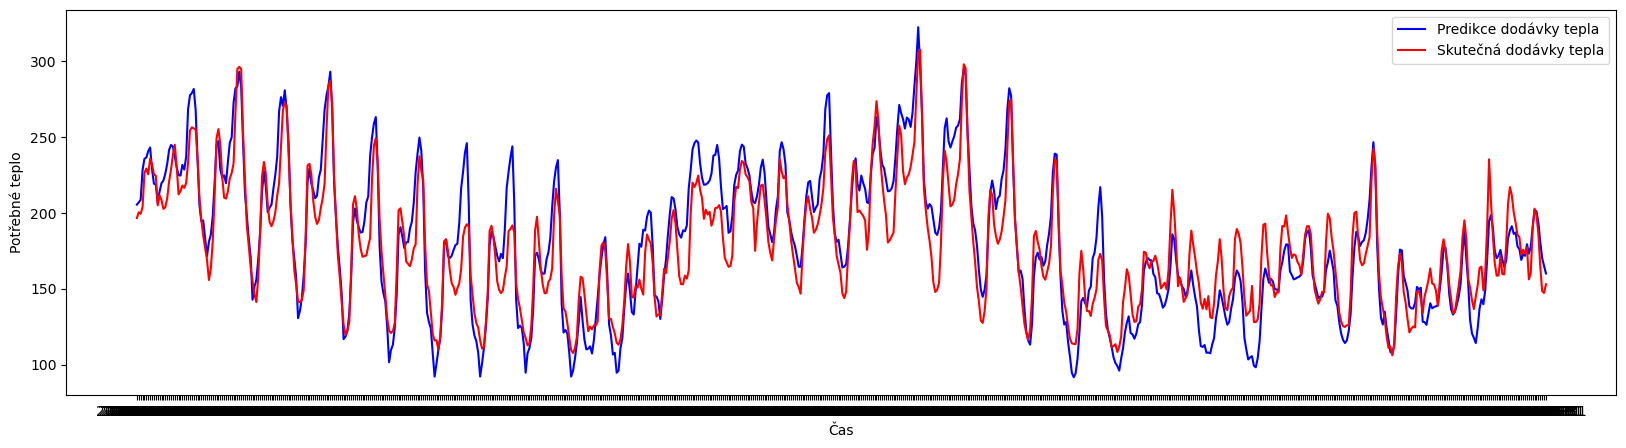

In [148]:
new_data = pd.read_excel(r'c:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\kontrolo_modelu_data\nový model\Venkovní_teplota.xlsx')
new_data["Teplota venkovní"] = new_data["Teplota venkovní"].astype(str).str.replace(',', '.').astype(float)
new_data["Datum"] = pd.to_datetime(new_data["Datum"], format="%d.%m.%y %H:%M")
new_data = new_data.set_index("Datum")
print(new_data.columns)

hyperparameters(new_data)

model = joblib.load(r'c:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\model_EPRU_novy_model_2.pkl')

X_new = new_data[['Teplota venkovní', 'hodina', 'je_leto']]

new_data["Predikce dodávky tepla"] = model.predict(X_new)

epru = pd.read_excel(r"c:\Users\pekarekmic1\OneDrive - Skupina ČEZ\Plocha\práce\#30 Prediktivní model EPRU\kontrolo_modelu_data\nový model\EPRU_výsup.xlsx")

epru["Datum"] = pd.to_datetime(epru["Datum"], format="%d.%m.%y %H:%M")
epru = epru.set_index("Datum")
epru["hodina"] = new_data.index


datum_od = "2025-03-01 00:00:00"
datum_do = "2025-04-30 00:00:00"

epru1 = epru
epru1 = epru1[(epru.index >= datum_od) & (epru.index < datum_do)]
new_data = new_data[(new_data.index >= datum_od) & (new_data.index < datum_do)]  
#df = df_final[(df_final.index >= "2024-01-01 00:00:00") & (df_final.index < "2024-01-10 00:00:00")]     
#df = df.head(100)

plt.figure(figsize=(20, 5))
plt.plot(new_data.index, new_data["Predikce dodávky tepla"], label="Predikce dodávky tepla", color="blue")
plt.plot(epru1.hodina, epru1["Dodavka"], label="Skutečná dodávky tepla", color="red")
plt.xlabel("Čas")
plt.xticks(new_data.index)
plt.ylabel("Potřebné teplo")
plt.legend()
plt.show()